In [1]:
## predict age with brain imaging features
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
print(mpl.__version__)
#from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
#from sklearn import datasets, linear_model

from my_fun import read_brain_feature

brain_feature_list, subject_id = read_brain_feature()

# newly merged file (SUBJID and bblid) with pandas:
pnc_behav_mental = pd.read_csv("data/pyresult01_pnc_behav_mental.csv", delimiter = ",")
print(pnc_behav_mental.shape)

subject_info_merge = subject_id.merge(pnc_behav_mental, how = "left", left_on = "names", right_on = "SUBJID")
print(subject_info_merge.shape)

head_motion_subjects = pd.read_csv("data/head_motion_subject_delete.txt", delimiter = "\t", header = None)
#print(head_motion_subjects)
head_motion_sublist = head_motion_subjects.iloc[:,0].tolist()
subject_info_merge = subject_info_merge[~subject_info_merge.SUBJID.isin(head_motion_sublist)]

# remove samples with Med_rating higher than 1:
subject_info_merge["Med_Rating"] = subject_info_merge["Med_Rating"].apply(pd.to_numeric, errors='coerce')
subject_info_merge = subject_info_merge.loc[subject_info_merge["Med_Rating"]<2,:]
subject_info_merge['Sex'] = subject_info_merge['Sex'].apply({'F':0, 'M':1}.get)

subject_info_merge.to_csv("data/script01_disorders_subject_info_merge.csv", sep = ",")
      
print(subject_info_merge.head())
subject_info_columns = ['SUBJID', 'Sex', 'age_at_cnb']

2.2.2
cat_vbm:
(856, 143)
label fa:
(856, 50)
tract fa:
(856, 20)
tract md:
(856, 20)
label md:
(856, 50)
alff
(856, 246)
falff
(856, 246)
reho
(856, 246)
(8519, 181)
(856, 182)
          names     bblid        SUBJID  Sex  Med_Rating  age_at_cnb  \
0  600009963128  117129.0  6.000100e+11    0         1.0         9.0   
1  600018902293  127386.0  6.000189e+11    0         1.0        15.0   
3  600038720566   94599.0  6.000387e+11    0         1.0        11.0   
4  600039015048  101501.0  6.000390e+11    1         1.0        11.0   
5  600039665619  101368.0  6.000397e+11    1         1.0         9.0   

  battery_valid padt_genus padt_valid  padt_a     ...      smry_hal_av  \
0             V     PADT36          V    23.0     ...              0.0   
1             V     PADT36          V    30.0     ...              0.0   
3             V     PADT36          V    23.0     ...              0.0   
4             V     PADT36          V    22.0     ...              0.0   
5             V    

/home/xin/environments/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# select disorders:
# disorders = ['smry_man', 'smry_dep', 'smry_gad', 'smry_sep', 'smry_phb',
#              'smry_soc','smry_pan','smry_agr','smry_ocd']

disorders = ['smry_ptd', 'smry_dep', 'smry_phb', 'smry_soc', 'smry_agr']

subject_info_hc = subject_info_merge.loc[subject_info_merge["mental_hc1"]==True, subject_info_columns]
print(subject_info_hc.shape)

subject_info_disorders = []
for dis in disorders:
    subject_info_dis = subject_info_merge.loc[subject_info_merge[dis]==4]
    print(dis)
    print(subject_info_dis.shape)
    subject_info_disorders.append(subject_info_dis)



(52, 3)
smry_ptd
(60, 182)
smry_dep
(67, 182)
smry_phb
(182, 182)
smry_soc
(139, 182)
smry_agr
(28, 182)


In [3]:
print("Healthy control:")
print("number of subjects: %d" % subject_info_hc.shape[0])
print("meam  and std of age: %.2f %.2f" % (subject_info_hc["age_at_cnb"].mean(),\
                                           subject_info_hc["age_at_cnb"].std()))
print("range of age: %d - %d" % (subject_info_hc["age_at_cnb"].max(),\
                                 subject_info_hc["age_at_cnb"].min()))

print("number of females: %d" % subject_info_hc.loc[subject_info_hc['Sex']==0,:].shape[0])
print("number of males: %d" % subject_info_hc.loc[subject_info_hc['Sex']==1,:].shape[0])


Healthy control:
number of subjects: 52
meam  and std of age: 14.63 3.99
range of age: 21 - 8
number of females: 26
number of males: 26


In [4]:
# train model with all HC data:
from my_fun import get_feature

# brain_feature = brain_feature_list[len(brain_feature_list)-1][0]
# feature_name = brain_feature_list[len(brain_feature_list)-1][1]
# print(feature_name)

#feature_idx = 5
# feature_idx = 8
feature_idx = 6 # GMV&rsfMRI
#feature_idx = 0


brain_feature = brain_feature_list[feature_idx][0]
feature_name = brain_feature_list[feature_idx][1]
print(feature_name)


# merge subject info with brain imaging data:
X_hc, y_hc, id_hc = get_feature(brain_feature, subject_info_hc)
# print(y_hc)
# print(X_hc)

X_disorder_list = []
y_disorder_list = []
subject_id_list = []

for i_dis in range(len(disorders)):
    # read disorder data:
    X_dis, y_dis, id_dis = get_feature(brain_feature, subject_info_disorders[i_dis])
    X_disorder_list.append(X_dis)
    y_disorder_list.append(y_dis)
    subject_id_list.append(id_dis)


GMV&rsfMRI


In [5]:
################################################# ridge ##################################
from sklearn.linear_model import RidgeCV


# ridge regression:
alpha = np.power(10, np.linspace(-3, 3, num = 10))
# print(alpha)
nfold = 3
ridge_cv = RidgeCV(alphas=alpha, cv = nfold)


baseline_history = ridge_cv.fit(X_hc, y_hc)

y_pred_list = []
for i_dis in range(len(disorders)):

    X_dis = X_disorder_list[i_dis]
    y_pred = ridge_cv.predict(X_dis)
    y_pred_list.append(y_pred)



In [6]:
# save results of ridge:
import os
directory = 'result/disorders'

if not os.path.exists(directory):
    os.makedirs(directory)

result_list = []
for i_dis in range(len(disorders)):
    
    y_dis = y_disorder_list[i_dis]
    y_pred = y_pred_list[i_dis]
    sub_id = subject_id_list[i_dis]
    
    d = {'SUBJID': sub_id,
         'age': y_dis,
         'predict age': y_pred}
    
    result_list.append(pd.DataFrame(d))
    
result_table = pd.concat(result_list, keys = disorders)
result_table.index = result_table.index.droplevel(1)

# print(result_table)
result_table.to_csv(directory + '/age_prediction_ridge_' + feature_name + '.csv')  


In [7]:
################################################# gpr ##################################

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel as CK

# GPR:
gpr_kernel = 1.0 * RBF(length_scale=10, length_scale_bounds=(1e-2, 1e3)) \
                    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

gpr_kernel2 = 1.0 * RBF(length_scale=100, length_scale_bounds=(1e-2, 1e3)) \
                    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

gpr_kernel3 = 1.0 * RBF(length_scale=1000, length_scale_bounds=(1e-2, 1e3)) \
                    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

gpr_kernel4 = CK(2.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) \
                    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gpr_kernel4 = 1.0 * RBF(length_scale=100, length_scale_bounds=(1e-2, 1e3))

# gpr_alpha = np.power(10, np.linspace(-3, 3, num = 10))

gpr_alpha = np.linspace(0,.1, num = 3)
param_grid_gpr = dict(alpha = gpr_alpha, kernel=[gpr_kernel, gpr_kernel2, gpr_kernel3, gpr_kernel4])
grid_gpr = GridSearchCV(estimator=GaussianProcessRegressor(), \
                                param_grid=param_grid_gpr, n_jobs=3, refit = True)


baseline_history = grid_gpr.fit(X_hc, y_hc)

y_pred_list = []
for i_dis in range(len(disorders)):

    X_dis = X_disorder_list[i_dis]
    y_pred = grid_gpr.predict(X_dis)
    y_pred_list.append(y_pred)

In [8]:
# save results of gpr:
import os
directory = 'result/disorders'

if not os.path.exists(directory):
    os.makedirs(directory)

result_list = []
for i_dis in range(len(disorders)):
    
    y_dis = y_disorder_list[i_dis]
    y_pred = y_pred_list[i_dis]
    sub_id = subject_id_list[i_dis]
    
    d = {'SUBJID': sub_id,
         'age': y_dis,
         'predict age': y_pred}
    
    result_list.append(pd.DataFrame(d))
    
result_table = pd.concat(result_list, keys = disorders)
result_table.index = result_table.index.droplevel(1)

# print(result_table)
result_table.to_csv(directory + '/age_prediction_gpr_' + feature_name + '.csv')  

In [9]:
############################################### SVR: #########################################
from sklearn.svm import SVR
import numpy as np

C = np.power(10, np.linspace(-1,2, num = 20))
epsilon=np.linspace(.001, 1, num = 20)

param_grid_svr = dict(C = C, epsilon = epsilon)
# linear model takes very long time to run.
#grid_svr = GridSearchCV(estimator=SVR(kernel='linear'), param_grid=param_grid_svr, n_jobs=3, refit = True)
# use default kernel rbf:
grid_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid_svr, n_jobs=3, refit = True)

baseline_history = grid_svr.fit(X_hc, y_hc)

y_pred_list = []
for i_dis in range(len(disorders)):

    X_dis = X_disorder_list[i_dis]
    y_pred = grid_svr.predict(X_dis)
    y_pred_list.append(y_pred)

In [10]:
# save results of gpr:
import os
directory = 'result/disorders'

if not os.path.exists(directory):
    os.makedirs(directory)

result_list = []
for i_dis in range(len(disorders)):
    
    y_dis = y_disorder_list[i_dis]
    y_pred = y_pred_list[i_dis]
    sub_id = subject_id_list[i_dis]
    
    d = {'SUBJID': sub_id,
         'age': y_dis,
         'predict age': y_pred}
    
    result_list.append(pd.DataFrame(d))
    
result_table = pd.concat(result_list, keys = disorders)
result_table.index = result_table.index.droplevel(1)

# print(result_table)
result_table.to_csv(directory + '/age_prediction_svr_' + feature_name + '.csv')  

In [11]:
############################################# DNN (pytorch) #######################################
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from skorch import NeuralNetClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from collections import OrderedDict

torch.manual_seed(999)    # reproducible
# https://discuss.pytorch.org/t/size-mismatch-beginner-troubles/16789
# model setup

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def weights_init(m):
    if isinstance(m, nn.Linear):
        print('initialize weight...')
        nn.init.xavier_uniform_(m.weight.data) 

def create_plot():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.ion() #Turn the interactive mode on.
    fig.show()
    fig.canvas.draw()
    return(fig)
    
    
def update_plot(fig, plot_list, loss_info):
    
    ax = plt.gca()
    plt.ion() #Turn the interactive mode on.
    ax.clear()
    
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
    
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    fig.canvas.draw()
    
def end_plot(fig, plot_list, loss_info, opt_loss_info, opt_epochs):
    plt.ion() #Turn the interactive mode on.
    ax = plt.gca()
    ax.clear()
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
        
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    plt.text(10, 20 , opt_loss_info, fontsize=10)
    ax.axvline(opt_epochs)
    fig.canvas.draw()
    

def transform_variable(X, y):
    
    X_train_torch = Variable(torch.from_numpy(X))
    y_train_torch = Variable(torch.from_numpy(y))
    
    X_train_torch = X_train_torch.float()
    y_train_torch = y_train_torch.float()

    labels = y_train_torch.view(y.shape[0],1)
    
    return (X_train_torch, labels)


class Model(nn.Module): 
    
    def __init__(self, min_loss = .5, l_rate = .001, max_epochs = 10000):
        
        super(Model, self).__init__() 
        self.min_loss = min_loss
        self.l_rate = l_rate
        self.max_epochs = max_epochs
    
        
    def build_layer(self, input_dim):
        
        if input_dim<100:
            n_units = [input_dim, 100, 50, 20, 1]
        elif input_dim<200:
            #n_units = [input_dim, 100, 100, 50, 20, 1] 
            n_units = [input_dim, 200, 100, 50, 20, 5, 1]
        elif input_dim<300:
            n_units = [input_dim, 200, 100, 50, 20, 1]      
        else:
            n_units = [input_dim, 400, 150, 50, 30, 5, 1]
        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.n_layers = len(n_units)-1
        
        layers = OrderedDict()
        for i in range(self.n_layers):
            n_hidden = n_units[i]
            n_hidden2 = n_units[i+1]
            
            layers[str(i)] = nn.Linear(n_hidden, n_hidden2)
            
        self.layers = nn.Sequential(layers)  
        print("build layer:")
        print(self)
        
        self.optimizer = torch.optim.SGD(self.parameters(), 
                                    lr = self.l_rate, 
                                    weight_decay=1e-3, 
                                    momentum=0.9, 
                                    dampening = 0,
                                    nesterov=True) #Stochastic Gradient Descent 
        
        #self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=.8)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, 
                                                              milestones=[500, 1000, 1500, 3000, 6000], 
                                                              gamma=0.5)
        
#         optimizer = torch.optim.Adagrad(self.parameters(), 
#                                         lr = self.l_rate, 
#                                         lr_decay = 1e-9,
#                                         weight_decay=1e-9,
#                                        )

        self.criterion = nn.MSELoss()# Mean Squared Loss
    
    def forward (self, x, **kwargs):

        for i in range(self.n_layers):
            #layer = eval('self.layer' + str(i+1))
            layer = self.layers[i]
            
            if i==0:
                # the 1st layer:
                out = F.relu(layer(x))
                #out = self.dropout(out)
            elif i<self.n_layers-2:
                # the middle layers use sigmoid.
                out = self.sigmoid(layer(out))
                #out = self.dropout(out)
            elif i==self.n_layers-2:
                out = F.relu(layer(out))
                #out = self.dropout(out)
            else:
                y_pred = layer(out) # linear output
            
        return y_pred
    
    
    def grad_decent(self, X_train_torch, labels):
        self.scheduler.step()
        #clear grads 
        self.optimizer.zero_grad()
        #forward to get predicted values
        outputs = self(X_train_torch) # model predict,  outputs = net.forward(inputs)

        loss = self.criterion(outputs, labels)
        loss.backward()# back props
        self.optimizer.step()# update the parameters 
        self.loss = loss
    
    
    def fit (self, X, y, ):
        """
        Fit model with all the input samples. It is recommended to first use fit_cv to determined the 
        optimized value of min_loss.
        """
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])

        torch.manual_seed(999) 
        self.apply(weights_init)
        print('training with all training data:')
        opt_loss_mean = -9999

        X_train_torch, labels = transform_variable(X, y)

        loss_list = []
        epoch = 0
        fig = create_plot()
        
        while True:            
            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()
            loss_list = np.append(loss_list, loss)

            if epoch % 10 == 0:
                loss_info = 'epoch %d, loss %.4f' % (epoch, loss)
                update_plot(fig, [loss_list], loss_info)
                fig.canvas.draw()

            # define the mean loss to prevent overfitting.
            if loss<min_loss or epoch>max_epochs:
                print('stop with loss:', loss)
                break
                
        plt.ioff()
    
    
    def fit_cv (self, X_train, y_train, X_test, y_test):
        """
        Use test data to compute validation accuracy.
        """
        
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])
        X_train_torch, labels = transform_variable(X_train, y_train)

        # Collect errors to evaluate performance
        loss_list = []
        corr_list = []

        torch.manual_seed(999)
        #self.apply(weights_init)

        epoch = 0
        fig = create_plot()
        while True:

            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()

            y_prediction = self.predict(X_test)

            corr = np.corrcoef(y_prediction, y_test)[0,1]
            corr_list = np.append(corr_list, corr) 
            loss_list = np.append(loss_list, loss)

            max_corr = np.amax(corr_list)

            if epoch % 50 == 0:
                loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)
                update_plot(fig, [loss_list, corr_list*10], loss_info)

            if epoch>max_epochs or loss< min_loss:
                break

        corr_list_s = smooth(corr_list, box_pts = 100)
        opt_epochs = corr_list_s.argmax()
        opt_loss = loss_list[opt_epochs]

        print('max coor at epochs: %d, loss %.4f, with test cor: %.4f' % 
              (opt_epochs, opt_loss, corr_list[opt_epochs]))

        loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)

        opt_loss_info = 'opt_epoch %d, opt_loss %.4f, test cor %.4f' % \
            (opt_epochs, opt_loss, corr_list[opt_epochs])

        update_plot(fig, [loss_list, corr_list*10], loss_info)
        end_plot(fig, [loss_list, corr_list*10], loss_info, opt_loss_info, opt_epochs)

        
        return(opt_loss)

    
    def predict(self, X_test):
        
        X_test_torch = Variable(torch.from_numpy(X_test))
        X_test_torch = X_test_torch.float()
        
        y_prediction = self(X_test_torch)
        y_prediction = y_prediction.detach().numpy().flatten()
        
        return y_prediction



build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


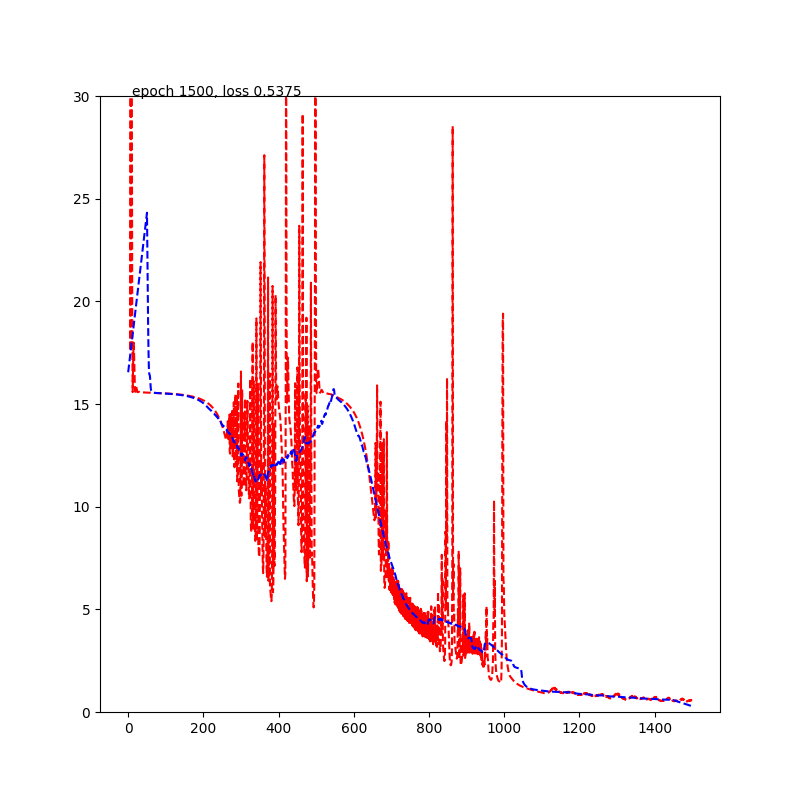

stop with loss: 0.3063945174217224


In [12]:
%matplotlib notebook

net = Model()
net.fit(X_hc, y_hc)

In [13]:
print('training accuracy:')
Y_train_prediction_dnn = net.predict(X_hc)
acc = np.corrcoef(y_hc, Y_train_prediction_dnn)
print(acc[0,1])

y_pred_list = []
for i_dis in range(len(disorders)):

    X_dis = X_disorder_list[i_dis]
    y_pred = net.predict(X_dis)
    y_pred_list.append(y_pred)


training accuracy:
0.9903704373292734


In [14]:
result_list = []
for i_dis in range(len(disorders)):
    
    y_dis = y_disorder_list[i_dis]
    y_pred = y_pred_list[i_dis]
    sub_id = subject_id_list[i_dis]
    
    d = {'SUBJID': sub_id,
         'age': y_dis,
         'predict age': y_pred}
    
    result_list.append(pd.DataFrame(d))
    
result_table = pd.concat(result_list, keys = disorders)
result_table.index = result_table.index.droplevel(1)

# print(result_table)
result_table.to_csv(directory + '/age_prediction_dnn_' + feature_name + '.csv')  